In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [29]:
# q_in, q_switch, q_out1, q_out2
EJs = [21, 20, 22, 21.5]
ECs = [0.25, 0.35, 0.35, 0.28]
gs = [0.1, 0.1, 0.1] # g12, g23, g24
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print(qubit_freqs[0], qubit_freqs[1], qubit_freqs[2], qubit_freqs[3])
print(alphas[0], alphas[1], alphas[2], alphas[3])

6.219955176682236 7.114505318471956 7.480762973458866 6.647033320874119
-0.2765666000150251 -0.3976349542294244 -0.3947192737976515 -0.3114706721669016


In [30]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= 3 EXCITATIONS

# qram.check_state_mapping()

In [66]:
times = np.linspace(0, 1200, 400)
# times = np.linspace(0, 400, 200)

seq = PulseSequence(start_time=0)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03)
qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.04)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05) # repeat of pulse 0
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06)

# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=57.0470))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggeg'), amp=0.15, t_pulse=105.7047))
# seq.wait(seq.const_pulse(wd=get_wd('eegg', 'eggg'), amp=0.05, t_pulse=110.7383))
# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=1000))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggge'), amp=0.1, t_pulse=87.2483))

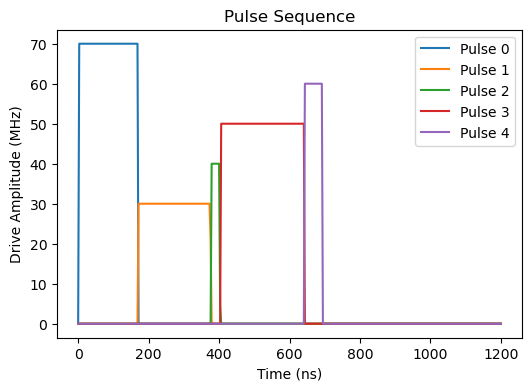

In [67]:
envelope_seq = seq.get_envelope_seq()
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [68]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.state('gggg')*qram.state('eggg').dag(),
    np.sqrt(1/T1)*qram.state('gggg')*qram.state('gegg').dag(),
    np.sqrt(1/T1)*qram.state('gggg')*qram.state('ggeg').dag(),
    np.sqrt(1/T1)*qram.state('gggg')*qram.state('ggge').dag(),
]

In [71]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(1/2) * qram.state('eggg') + np.sqrt(1/2) * qram.state('eegg') # QRAM start

if incl_dissipation:
    result = qt.mesolve(qram.H_solver(seq), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000)).states
else: result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states

10.0%. Run time:  14.48s. Est. time left: 00:00:02:10
20.0%. Run time:  32.81s. Est. time left: 00:00:02:11
30.0%. Run time:  52.12s. Est. time left: 00:00:02:01
40.0%. Run time:  72.52s. Est. time left: 00:00:01:48
50.0%. Run time:  92.64s. Est. time left: 00:00:01:32
60.0%. Run time: 113.25s. Est. time left: 00:00:01:15
70.0%. Run time: 134.04s. Est. time left: 00:00:00:57
80.0%. Run time: 154.90s. Est. time left: 00:00:00:38
90.0%. Run time: 176.56s. Est. time left: 00:00:00:19
Total run time: 196.91s


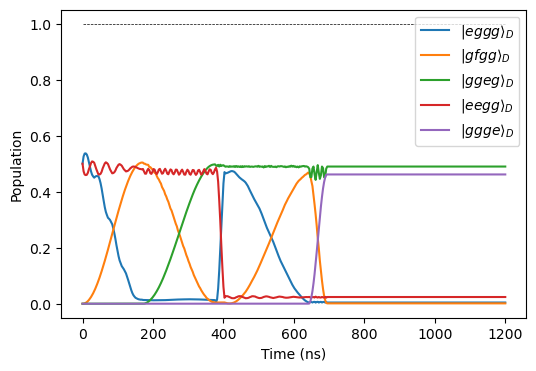

In [72]:
plt.plot(times, [np.abs(qram.state('eggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eggg\rangle_D$')
plt.plot(times, [np.abs(qram.state('gfgg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gfgg\rangle_D$')
plt.plot(times, [np.abs(qram.state('ggeg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggeg\rangle_D$')
plt.plot(times, [np.abs(qram.state('eegg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eegg\rangle_D$')
plt.plot(times, [np.abs(qram.state('ggge').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggge\rangle_D$')
# plt.plot(times, [np.abs(state('gggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gggg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
# plt.xlim(750, 1000)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.show()

In [10]:
T = 900 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                sum_psi += np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
print('Sum probabilities:', sum_psi)
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > 0.01: print(qram.level_nums_to_name([i1, i2, i3, i4]))

Sum probabilities: 0.9957964224105145
Non-zero levels:
ggge
ggeg
eggg


In [11]:
print('want', qram.get_wd('eggg', 'eegg')/2/np.pi)
print('resonant to', qram.get_wd('ggeg', 'geeg')/2/np.pi)
print('2 photon transition to', qram.get_wd('eggg', 'efgg')/2/np.pi)

want -7.02533029228321
resonant to -7.34452190391689
2 photon transition to -13.678492078654784
